####**SKENARIO 4 SKRIPSI**

**SPLIT DATA 70:30**

**AUGMENTASI OFFLINE**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN RS-UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)


# Verifikasi isi folder
!ls

best_class1_rsunet01.h5  best_rsunet8_model.h5	 maskedrsunet8_train
best_class1_rsunet1.h5	 best_unet01_model.h5	 maskedunet01_test
best_class1_rsunet2.h5	 best_unet1_model.h5	 maskedunet01_train
best_class1_rsunet7.h5	 best_unet2_model.h5	 maskedunet1_train
best_class1_rsunet8.h5	 best_unet3_model.h5	 maskedunet2_test
best_class1_unet01.h5	 best_unet4_model.h5	 maskedunet2_train
best_class1_unet1.h5	 images			 maskedunet3_test
best_class1_unet2.h5	 images_aug		 maskedunet3_train
best_class1_unet3.h5	 images_augment		 maskedunet4_test
best_class2_rsunet01.h5  labels_converted.csv	 maskedunet4_train
best_class2_rsunet1.h5	 labels.csv		 masks
best_class2_rsunet2.h5	 labels.gsheet		 masks_aug
best_class2_rsunet7.h5	 logs			 masks_augment
best_class2_rsunet8.h5	 maskedrsunet01_test	 model.ipynb
best_class2_unet01.h5	 maskedrsunet01_train	 training_history1.json
best_class2_unet1.h5	 maskedrsunet1_test	 training_history2.json
best_class2_unet3.h5	 maskedrsunet1_train	 training_history3.json

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images_aug/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks_aug/*.*'))

print(len(image_paths))
print(len(mask_paths))

5850
5850


In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}

# Jika kamu ingin tetap mendapatkan label numerik, kamu perlu membalik mapping-nya:
reverse_label_map = {v: k for k, v in label_map.items()}
labels = [reverse_label_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.3,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 1: 1365 data
Label 0: 1365 data
Label 2: 1365 data


##**DATA PREPROCESSING DAN AUGMENTASI**##

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [ ]:
# Dataset untuk train
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                  num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Dataset untuk test
test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

##**RS-UNET + SE MODEL**##

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def squeeze_excite_block(input, ratio=8):
    filters = input.shape[-1]
    se = GlobalAveragePooling2D()(input)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = Multiply()([input, se])
    return x

def build_resnet50_unet_se(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder dengan SE Block
    s1 = resnet50.get_layer("conv1_relu").output        ## (64 x 64)
    s1 = squeeze_excite_block(s1)

    s2 = resnet50.get_layer("conv2_block3_out").output  ## (32 x 32)
    s2 = squeeze_excite_block(s2)

    s3 = resnet50.get_layer("conv3_block4_out").output  ## (16 x 16)
    s3 = squeeze_excite_block(s3)

    s4 = resnet50.get_layer("conv4_block6_out").output  ## (8 x 8)
    s4 = squeeze_excite_block(s4)

    # Decoder
    d1 = decoder_block(s4, s3, 512)                     ## (16 x 16)
    d2 = decoder_block(d1, s2, 256)                     ## (32 x 32)
    d3 = decoder_block(d2, s1, 128)                     ## (64 x 64)
    d4 = decoder_block(d3, inputs, 64)                  ## (128 x 128)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="ResNet50_U-Net_SE")
    return model

# Build and summarize model
model = build_resnet50_unet_se(input_shape=(128, 128, 3))
model.summary()


Model: "ResNet50_U-Net_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 21,021,633 (80.19 MB)

 Trainable params: 20,987,201 (80.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_rsunet02_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)


Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - iou_metric: 0.8607 - loss: 0.1624 

256/256 ━━━━━━━━━━━━━━━━━━━━ 4697s 18s/step - iou_metric: 0.8609 - loss: 0.1621 - val_iou_metric: 0.2585 - val_loss: 3.1539
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - iou_metric: 0.9532 - loss: 0.0271

256/256 ━━━━━━━━━━━━━━━━━━━━ 103s 240ms/step - iou_metric: 0.9533 - loss: 0.0271 - val_iou_metric: 0.4401 - val_loss: 0.4448
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 215ms/step - iou_metric: 0.9650 - loss: 0.0180 - val_iou_metric: 0.2655 - val_loss: 2.1126
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - iou_metric: 0.9633 - loss: 0.0181

256/256 ━━━━━━━━━━━━━━━━━━━━ 93s 259ms/step - iou_metric: 0.9633 - loss: 0.0181 - val_iou_metric: 0.9558 - val_loss: 0.0249
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - iou_metric: 0.9739 - loss: 0.0125

256/256 ━━━━━━━━━━━━━━━━━━━━ 68s 261ms/step - iou_metric: 0.9739 - loss: 0.0125 - val_iou_metric: 0.9736 - val_loss: 0.0132
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 244ms/step - iou_metric: 0.9736 - loss: 0.0127 - val_iou_metric: 0.2866 - val_loss: 0.9821
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 225ms/step - iou_metric: 0.9556 - loss: 0.0229 - val_iou_metric: 0.9719 - val_loss: 0.0137
Epoch 8/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - iou_metric: 0.9770 - loss: 0.0108

256/256 ━━━━━━━━━━━━━━━━━━━━ 92s 263ms/step - iou_metric: 0.9770 - loss: 0.0108 - val_iou_metric: 0.9770 - val_loss: 0.0110
Epoch 9/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - iou_metric: 0.9798 - loss: 0.0094

256/256 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - iou_metric: 0.9798 - loss: 0.0094 - val_iou_metric: 0.9789 - val_loss: 0.0101
Epoch 10/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 242ms/step - iou_metric: 0.9816 - loss: 0.0085 - val_iou_metric: 0.9777 - val_loss: 0.0105
Epoch 11/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - iou_metric: 0.9823 - loss: 0.0081

256/256 ━━━━━━━━━━━━━━━━━━━━ 86s 257ms/step - iou_metric: 0.9823 - loss: 0.0081 - val_iou_metric: 0.9803 - val_loss: 0.0093
Epoch 12/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 217ms/step - iou_metric: 0.9840 - loss: 0.0073 - val_iou_metric: 0.9796 - val_loss: 0.0099
Epoch 13/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - iou_metric: 0.9841 - loss: 0.0073 - val_iou_metric: 0.8596 - val_loss: 0.2090
Epoch 14/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 216ms/step - iou_metric: 0.9710 - loss: 0.0143 - val_iou_metric: 0.9721 - val_loss: 0.0135
Epoch 15/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 57s 219ms/step - iou_metric: 0.9770 - loss: 0.0110 - val_iou_metric: 0.9737 - val_loss: 0.0124
Epoch 16/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - iou_metric: 0.9823 - loss: 0.0082

256/256 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - iou_metric: 0.9823 - loss: 0.0082 - val_iou_metric: 0.9809 - val_loss: 0.0090
Epoch 17/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - iou_metric: 0.9852 - loss: 0.0068

256/256 ━━━━━━━━━━━━━━━━━━━━ 90s 274ms/step - iou_metric: 0.9852 - loss: 0.0068 - val_iou_metric: 0.9818 - val_loss: 0.0087
Epoch 18/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - iou_metric: 0.9863 - loss: 0.0063 - val_iou_metric: 0.9705 - val_loss: 0.0184
Epoch 19/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 224ms/step - iou_metric: 0.9843 - loss: 0.0073 - val_iou_metric: 0.9717 - val_loss: 0.0177
Epoch 20/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - iou_metric: 0.9835 - loss: 0.0076

256/256 ━━━━━━━━━━━━━━━━━━━━ 65s 253ms/step - iou_metric: 0.9835 - loss: 0.0076 - val_iou_metric: 0.9821 - val_loss: 0.0084
Epoch 21/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - iou_metric: 0.9872 - loss: 0.0059

256/256 ━━━━━━━━━━━━━━━━━━━━ 84s 263ms/step - iou_metric: 0.9872 - loss: 0.0059 - val_iou_metric: 0.9833 - val_loss: 0.0082
Epoch 22/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 223ms/step - iou_metric: 0.9887 - loss: 0.0052 - val_iou_metric: 0.9831 - val_loss: 0.0085
Epoch 23/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - iou_metric: 0.9894 - loss: 0.0049 - val_iou_metric: 0.9841 - val_loss: 0.0083
Epoch 24/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 224ms/step - iou_metric: 0.9902 - loss: 0.0045 - val_iou_metric: 0.9842 - val_loss: 0.0083
Epoch 25/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 226ms/step - iou_metric: 0.9909 - loss: 0.0042 - val_iou_metric: 0.9842 - val_loss: 0.0086
Epoch 26/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 226ms/step - iou_metric: 0.9915 - loss: 0.0040 - val_iou_metric: 0.9849 - val_loss: 0.0085
Epoch 27/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 58s 226ms/step - iou_metric: 0.9923 - loss: 0.0036 - val_iou_metric: 0.9840 - val_loss: 0.0092
Epoch 28/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 217ms/st

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history_rsunet02.json', 'w') as json_file:
    json.dump(history_dict, json_file)

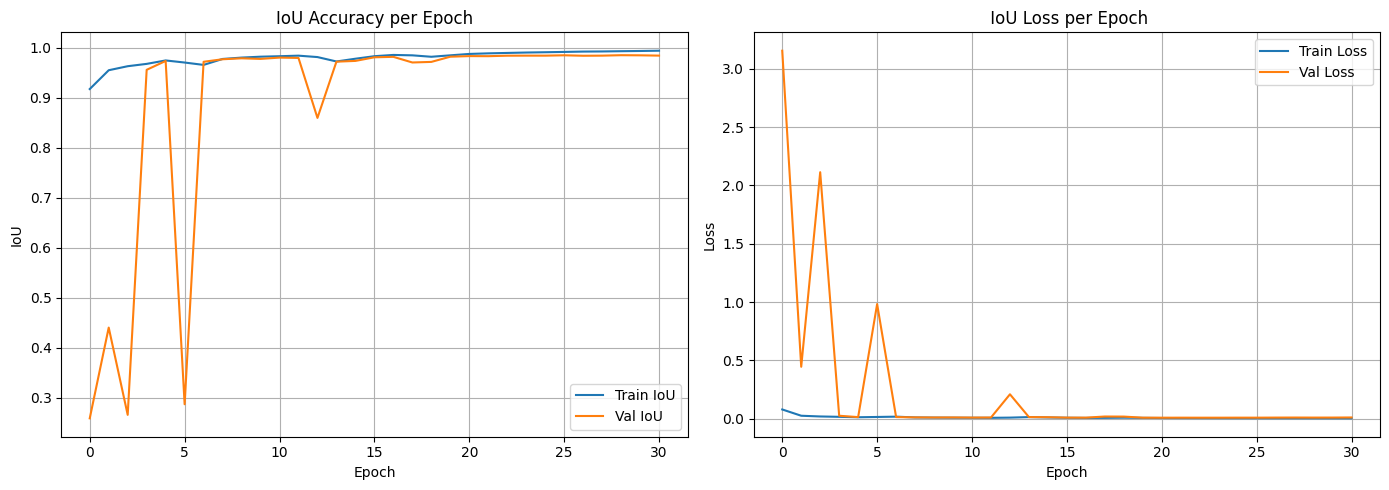

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


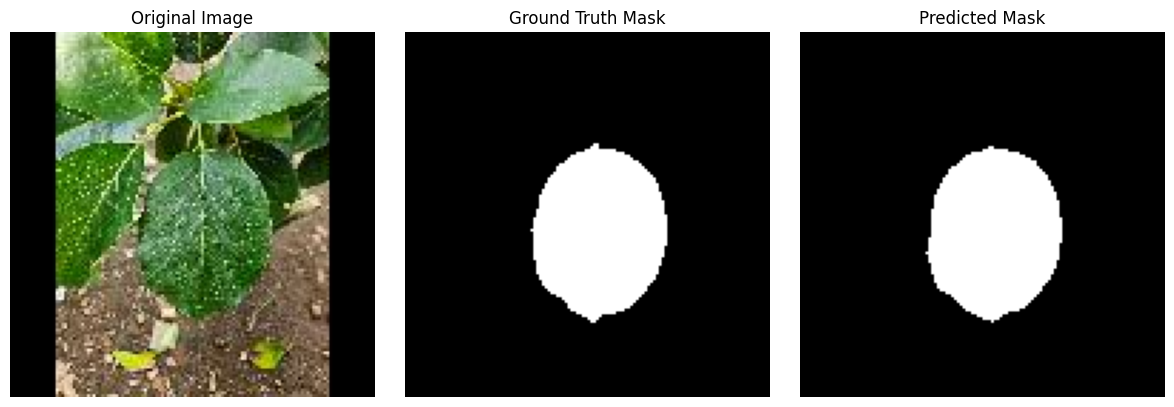

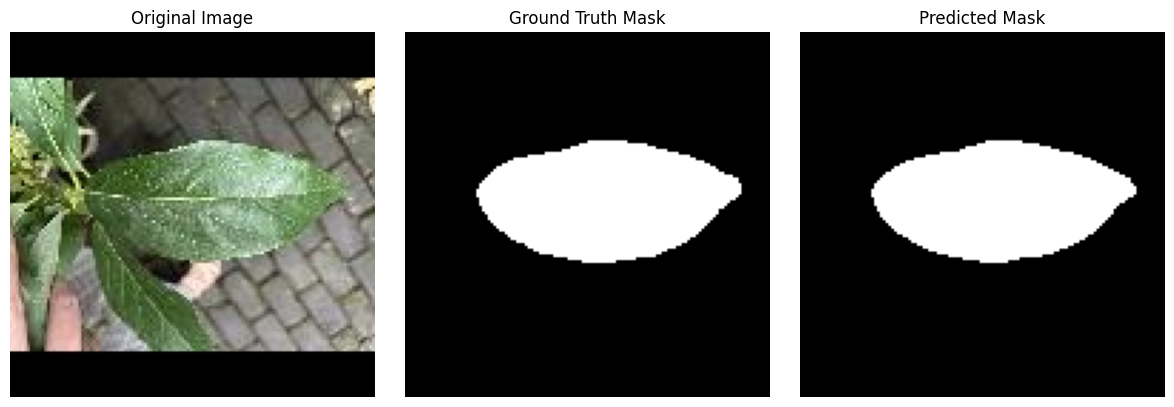

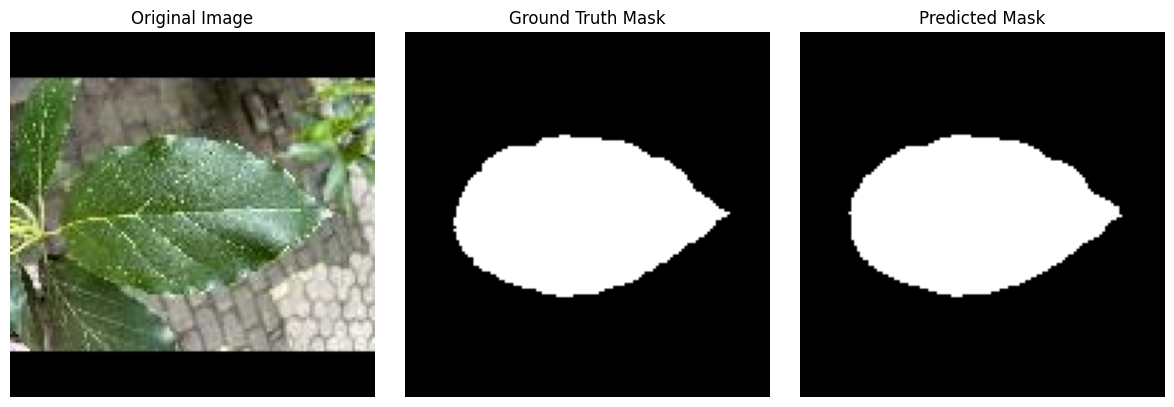

In [ ]:
def display_sample_prediction(model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
# from tensorflow.keras.models import load_model

# # Load model U-Net dari checkpoint
# unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_unet2_model.h5')

In [ ]:
import tensorflow as tf

# Mapping string ke angka (lowercase)
reverse_label_map = {v.lower(): k for k, v in label_map.items()}

# TensorFlow lookup table
keys_tensor = tf.constant(list(reverse_label_map.keys()))
vals_tensor = tf.constant(list(reverse_label_map.values()), dtype=tf.int32)

table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# Fungsi untuk mengambil label dari nama file
def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)


In [ ]:
def apply_rsunet_segmentation_to_image(image, outputs, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(outputs > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import os

def save_masked_dataset(image_paths, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load image (sudah 128x128 dan normalisasi dilakukan saat load_image_and_label)
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisasi dilakukan sekali saja di sini jika tidak dilakukan sebelumnya

        # Predict mask
        pred = model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_rsunet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)

In [ ]:
save_masked_dataset(train_image_paths, model, "maskedrsunet02_train")
save_masked_dataset(test_image_paths, model, "maskedrsunet02_test")

100%|██████████| 1755/1755 [07:11<00:00,  4.07it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedrsunet02_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedrsunet02_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedrsunet02_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedrsunet02_test").batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_rsunet02.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_rsunet02.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3484 - loss: 1.0925

256/256 ━━━━━━━━━━━━━━━━━━━━ 54s 185ms/step - accuracy: 0.3486 - loss: 1.0924 - val_accuracy: 0.5242 - val_loss: 0.9924
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5313 - loss: 0.9535

256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.5315 - loss: 0.9532 - val_accuracy: 0.7658 - val_loss: 0.6279
Epoch 3/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7448 - loss: 0.6429

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7448 - loss: 0.6427 - val_accuracy: 0.7379 - val_loss: 0.6212
Epoch 4/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7610 - loss: 0.5836

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.7611 - loss: 0.5834 - val_accuracy: 0.7840 - val_loss: 0.4905
Epoch 5/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7806 - loss: 0.5376

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7808 - loss: 0.5373 - val_accuracy: 0.8313 - val_loss: 0.3990
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8110 - loss: 0.4585 - val_accuracy: 0.8211 - val_loss: 0.4129
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8103 - loss: 0.4650

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8103 - loss: 0.4649 - val_accuracy: 0.8439 - val_loss: 0.3724
Epoch 8/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8224 - loss: 0.4325

256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8225 - loss: 0.4324 - val_accuracy: 0.8405 - val_loss: 0.3647
Epoch 9/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8419 - loss: 0.4042

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8420 - loss: 0.4041 - val_accuracy: 0.8382 - val_loss: 0.3642
Epoch 10/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8494 - loss: 0.3970

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.8494 - loss: 0.3969 - val_accuracy: 0.8632 - val_loss: 0.3200
Epoch 11/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8565 - loss: 0.3590

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8565 - loss: 0.3589 - val_accuracy: 0.8815 - val_loss: 0.2853
Epoch 12/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.8612 - loss: 0.3527 - val_accuracy: 0.8228 - val_loss: 0.3683
Epoch 13/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.8592 - loss: 0.3578 - val_accuracy: 0.8222 - val_loss: 0.3805
Epoch 14/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.8671 - loss: 0.3262 - val_accuracy: 0.8575 - val_loss: 0.3086
Epoch 15/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8891 - loss: 0.2990

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.8891 - loss: 0.2990 - val_accuracy: 0.9009 - val_loss: 0.2451
Epoch 16/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8948 - loss: 0.2810 - val_accuracy: 0.8718 - val_loss: 0.3129
Epoch 17/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8998 - loss: 0.2664 - val_accuracy: 0.8632 - val_loss: 0.2934
Epoch 18/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9047 - loss: 0.2677 - val_accuracy: 0.8809 - val_loss: 0.2743
Epoch 19/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9085 - loss: 0.2470 - val_accuracy: 0.8678 - val_loss: 0.3109
Epoch 20/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9057 - loss: 0.2562 - val_accuracy: 0.8997 - val_loss: 0.2492
Epoch 21/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9119 - loss: 0.2335

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9118 - loss: 0.2336 - val_accuracy: 0.9020 - val_loss: 0.2445
Epoch 22/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9156 - loss: 0.2240

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9156 - loss: 0.2240 - val_accuracy: 0.9066 - val_loss: 0.2347
Epoch 23/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9279 - loss: 0.2035

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9278 - loss: 0.2036 - val_accuracy: 0.9151 - val_loss: 0.2216
Epoch 24/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9301 - loss: 0.1890

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9300 - loss: 0.1891 - val_accuracy: 0.9191 - val_loss: 0.2057
Epoch 25/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9231 - loss: 0.1925

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9230 - loss: 0.1925 - val_accuracy: 0.9248 - val_loss: 0.1909
Epoch 26/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9315 - loss: 0.1811

256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9315 - loss: 0.1811 - val_accuracy: 0.9254 - val_loss: 0.1898
Epoch 27/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9293 - loss: 0.1960 - val_accuracy: 0.9151 - val_loss: 0.2091
Epoch 28/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9309 - loss: 0.1933

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9309 - loss: 0.1932 - val_accuracy: 0.9470 - val_loss: 0.1468
Epoch 29/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9309 - loss: 0.1697 - val_accuracy: 0.9242 - val_loss: 0.1827
Epoch 30/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9404 - loss: 0.1628 - val_accuracy: 0.9316 - val_loss: 0.1835
Epoch 31/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9427 - loss: 0.1488 - val_accuracy: 0.9066 - val_loss: 0.2264
Epoch 32/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9461 - loss: 0.1470 - val_accuracy: 0.8741 - val_loss: 0.2998
Epoch 33/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9388 - loss: 0.1726 - val_accuracy: 0.8974 - val_loss: 0.2516
Epoch 34/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9470 - loss: 0.1523

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9470 - loss: 0.1523 - val_accuracy: 0.9544 - val_loss: 0.1268
Epoch 35/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9501 - loss: 0.1374 - val_accuracy: 0.9009 - val_loss: 0.2264
Epoch 36/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9501 - loss: 0.1483 - val_accuracy: 0.9162 - val_loss: 0.2078
Epoch 37/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9547 - loss: 0.1121 - val_accuracy: 0.8547 - val_loss: 0.4340
Epoch 38/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9473 - loss: 0.1477 - val_accuracy: 0.9305 - val_loss: 0.1810
Epoch 39/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9544 - loss: 0.1267 - val_accuracy: 0.9430 - val_loss: 0.1492
Epoch 40/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9571 - loss: 0.1190 - val_accuracy: 0.9339 - val_loss: 0.1707
Epoch 41/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9668 - loss: 0.0936

256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9726 - loss: 0.0761 - val_accuracy: 0.9652 - val_loss: 0.1058
Epoch 54/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9785 - loss: 0.0629 - val_accuracy: 0.9442 - val_loss: 0.1502
Epoch 55/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9811 - loss: 0.0613 - val_accuracy: 0.9647 - val_loss: 0.1085
Epoch 56/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9859 - loss: 0.0446 - val_accuracy: 0.9533 - val_loss: 0.1204
Epoch 57/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9791 - loss: 0.0583 - val_accuracy: 0.9442 - val_loss: 0.1619
Epoch 58/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9780 - loss: 0.0622 - val_accuracy: 0.9499 - val_loss: 0.1422
Epoch 59/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9838 - loss: 0.0502 - val_accuracy: 0.9345 - val_loss: 0.2214
Epoch 60/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9664 - loss: 0.0966

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9733 - loss: 0.0738 - val_accuracy: 0.9778 - val_loss: 0.0721
Epoch 62/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9858 - loss: 0.0417 - val_accuracy: 0.9687 - val_loss: 0.0866
Epoch 63/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9712 - loss: 0.0730 - val_accuracy: 0.9652 - val_loss: 0.1058
Epoch 64/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9811 - loss: 0.0544 - val_accuracy: 0.9618 - val_loss: 0.1230
Epoch 65/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9892 - loss: 0.0445 - val_accuracy: 0.9447 - val_loss: 0.1568
Epoch 66/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9825 - loss: 0.0397 - val_accuracy: 0.9561 - val_loss: 0.1302
Epoch 67/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9888 - loss: 0.0305 - val_accuracy: 0.9647 - val_loss: 0.0943
Epoch 68/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9731 - loss: 0.0737

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9731 - loss: 0.0736 - val_accuracy: 0.9789 - val_loss: 0.0681
Epoch 69/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9930 - loss: 0.0294 - val_accuracy: 0.9516 - val_loss: 0.1304
Epoch 70/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9854 - loss: 0.0470 - val_accuracy: 0.9772 - val_loss: 0.0687
Epoch 71/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9758 - loss: 0.0731 - val_accuracy: 0.9624 - val_loss: 0.1307
Epoch 72/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9895 - loss: 0.0316 - val_accuracy: 0.9761 - val_loss: 0.0769
Epoch 73/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9895 - loss: 0.0348

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9895 - loss: 0.0349 - val_accuracy: 0.9795 - val_loss: 0.0596
Epoch 74/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.8849 - val_loss: 0.6039
Epoch 75/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9789 - loss: 0.0914 - val_accuracy: 0.9840 - val_loss: 0.0665
Epoch 76/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9951 - loss: 0.0166 - val_accuracy: 0.9613 - val_loss: 0.0995
Epoch 77/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9675 - loss: 0.0985 - val_accuracy: 0.9533 - val_loss: 0.1447
Epoch 78/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9869 - loss: 0.0368 - val_accuracy: 0.9698 - val_loss: 0.0766
Epoch 79/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9851 - loss: 0.0486

256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9851 - loss: 0.0486 - val_accuracy: 0.9801 - val_loss: 0.0558
Epoch 80/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9895 - loss: 0.0286 - val_accuracy: 0.9835 - val_loss: 0.0685
Epoch 81/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9912 - loss: 0.0265

256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9912 - loss: 0.0266 - val_accuracy: 0.9846 - val_loss: 0.0524
Epoch 82/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9914 - loss: 0.0205 - val_accuracy: 0.9823 - val_loss: 0.0568
Epoch 83/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9935 - loss: 0.0227 - val_accuracy: 0.9670 - val_loss: 0.1049
Epoch 84/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9893 - loss: 0.0328 - val_accuracy: 0.9504 - val_loss: 0.1346
Epoch 85/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9830 - loss: 0.0550 - val_accuracy: 0.9732 - val_loss: 0.0924
Epoch 86/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9855 - loss: 0.0436 - val_accuracy: 0.9630 - val_loss: 0.1374
Epoch 87/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9837 - loss: 0.0469 - val_accuracy: 0.9607 - val_loss: 0.1067
Epoch 88/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9889 - loss: 0.0336

256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9912 - loss: 0.0309 - val_accuracy: 0.9886 - val_loss: 0.0453
Epoch 90/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9933 - loss: 0.0223 - val_accuracy: 0.9783 - val_loss: 0.0743
Epoch 91/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9968 - loss: 0.0100 - val_accuracy: 0.9801 - val_loss: 0.0683
Epoch 92/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9917 - loss: 0.0229 - val_accuracy: 0.9829 - val_loss: 0.0606
Epoch 93/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9939 - loss: 0.0177 - val_accuracy: 0.9578 - val_loss: 0.1091
Epoch 94/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9858 - loss: 0.0411 - val_accuracy: 0.9846 - val_loss: 0.0595
Epoch 95/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9953 - loss: 0.0176 - val_accuracy: 0.9476 - val_loss: 0.2134
Epoch 96/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9877 - loss: 0.0441

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

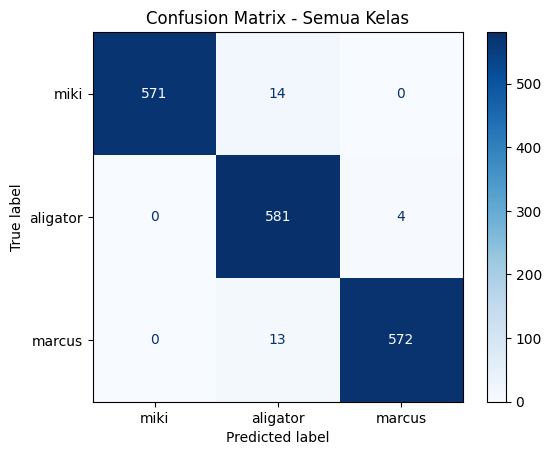

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.98      0.99       585
    aligator       0.96      0.99      0.97       585
      marcus       0.99      0.98      0.99       585

    accuracy                           0.98      1755
   macro avg       0.98      0.98      0.98      1755
weighted avg       0.98      0.98      0.98      1755

              precision    recall  f1-score      support
miki           1.000000  0.976068  0.987889   585.000000
aligator       0.955592  0.993162  0.974015   585.000000
marcus         0.993056  0.977778  0.985357   585.000000
accuracy       0.982336  0.982336  0.982336     0.982336
macro avg      0.982883  0.982336  0.982421  1755.000000
weighted avg   0.982883  0.982336  0.982421  1755.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

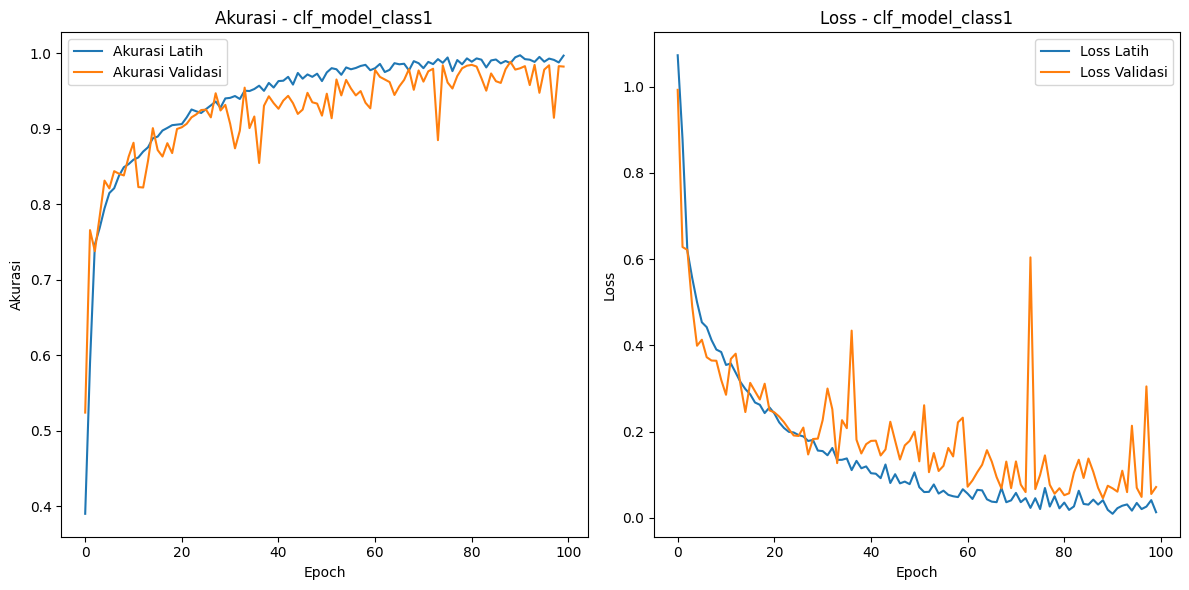

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3635 - loss: 1.0928

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.3637 - loss: 1.0927 - val_accuracy: 0.4729 - val_loss: 1.0055
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5224 - loss: 0.9832

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.5227 - loss: 0.9828 - val_accuracy: 0.6764 - val_loss: 0.7707
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6435 - loss: 0.8141

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6437 - loss: 0.8138 - val_accuracy: 0.7504 - val_loss: 0.6546
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7124 - loss: 0.6929

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.7125 - loss: 0.6926 - val_accuracy: 0.7732 - val_loss: 0.5384
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.7465 - loss: 0.6103 - val_accuracy: 0.7538 - val_loss: 0.5631
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7803 - loss: 0.5415

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7803 - loss: 0.5414 - val_accuracy: 0.8091 - val_loss: 0.4393
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7898 - loss: 0.5192

128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.7899 - loss: 0.5190 - val_accuracy: 0.8222 - val_loss: 0.4122
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.7995 - loss: 0.4872 - val_accuracy: 0.8188 - val_loss: 0.4143
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8142 - loss: 0.4586

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8142 - loss: 0.4586 - val_accuracy: 0.8387 - val_loss: 0.3764
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8264 - loss: 0.4405

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.8263 - loss: 0.4404 - val_accuracy: 0.8456 - val_loss: 0.3625
Epoch 11/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.8311 - loss: 0.4244 - val_accuracy: 0.8530 - val_loss: 0.3716
Epoch 12/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8314 - loss: 0.4105

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8314 - loss: 0.4104 - val_accuracy: 0.8587 - val_loss: 0.3386
Epoch 13/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8368 - loss: 0.3897

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8368 - loss: 0.3896 - val_accuracy: 0.8769 - val_loss: 0.3045
Epoch 14/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.8581 - loss: 0.3662 - val_accuracy: 0.8615 - val_loss: 0.3425
Epoch 15/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8497 - loss: 0.3770 - val_accuracy: 0.8650 - val_loss: 0.3110
Epoch 16/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.8402 - loss: 0.3800 - val_accuracy: 0.8655 - val_loss: 0.3174
Epoch 17/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.8702 - loss: 0.3336 - val_accuracy: 0.8490 - val_loss: 0.3250
Epoch 18/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8694 - loss: 0.3257

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8695 - loss: 0.3256 - val_accuracy: 0.9123 - val_loss: 0.2507
Epoch 19/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8731 - loss: 0.3174 - val_accuracy: 0.8735 - val_loss: 0.2921
Epoch 20/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.8698 - loss: 0.3179 - val_accuracy: 0.8650 - val_loss: 0.3142
Epoch 21/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.8893 - loss: 0.2865 - val_accuracy: 0.8923 - val_loss: 0.2520
Epoch 22/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.8950 - loss: 0.2607 - val_accuracy: 0.8821 - val_loss: 0.2664
Epoch 23/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9034 - loss: 0.2650

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9034 - loss: 0.2650 - val_accuracy: 0.9293 - val_loss: 0.2009
Epoch 24/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9057 - loss: 0.2377 - val_accuracy: 0.9094 - val_loss: 0.2196
Epoch 25/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.8987 - loss: 0.2723 - val_accuracy: 0.9271 - val_loss: 0.2039
Epoch 26/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.9122 - loss: 0.2429 - val_accuracy: 0.8986 - val_loss: 0.2475
Epoch 27/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8964 - loss: 0.2631 - val_accuracy: 0.9060 - val_loss: 0.2307
Epoch 28/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9149 - loss: 0.2317 - val_accuracy: 0.8650 - val_loss: 0.3067
Epoch 29/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9045 - loss: 0.2488

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9046 - loss: 0.2486 - val_accuracy: 0.9288 - val_loss: 0.1909
Epoch 30/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9060 - loss: 0.2494

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.9060 - loss: 0.2492 - val_accuracy: 0.9225 - val_loss: 0.1905
Epoch 31/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9228 - loss: 0.2129

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9228 - loss: 0.2129 - val_accuracy: 0.9276 - val_loss: 0.1873
Epoch 32/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9078 - loss: 0.2638

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.9078 - loss: 0.2636 - val_accuracy: 0.9333 - val_loss: 0.1830
Epoch 33/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9243 - loss: 0.2041

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9244 - loss: 0.2040 - val_accuracy: 0.9299 - val_loss: 0.1762
Epoch 34/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9280 - loss: 0.2022 - val_accuracy: 0.9185 - val_loss: 0.2144
Epoch 35/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.9360 - loss: 0.1832 - val_accuracy: 0.9003 - val_loss: 0.2297
Epoch 36/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9283 - loss: 0.1990

128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.9284 - loss: 0.1990 - val_accuracy: 0.9282 - val_loss: 0.1645
Epoch 37/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.9308 - loss: 0.1743 - val_accuracy: 0.9288 - val_loss: 0.1902
Epoch 38/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9391 - loss: 0.1626 - val_accuracy: 0.9140 - val_loss: 0.2055
Epoch 39/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9328 - loss: 0.1745 - val_accuracy: 0.9197 - val_loss: 0.1969
Epoch 40/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9377 - loss: 0.1617 - val_accuracy: 0.9179 - val_loss: 0.1857
Epoch 41/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9422 - loss: 0.1523

128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9422 - loss: 0.1523 - val_accuracy: 0.9322 - val_loss: 0.1626
Epoch 42/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9338 - loss: 0.1795 - val_accuracy: 0.9123 - val_loss: 0.2088
Epoch 43/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9386 - loss: 0.1712

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9387 - loss: 0.1711 - val_accuracy: 0.9390 - val_loss: 0.1587
Epoch 44/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9436 - loss: 0.1467

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9436 - loss: 0.1467 - val_accuracy: 0.9476 - val_loss: 0.1549
Epoch 45/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9482 - loss: 0.1439 - val_accuracy: 0.9197 - val_loss: 0.2095
Epoch 46/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9470 - loss: 0.1485 - val_accuracy: 0.9299 - val_loss: 0.1826
Epoch 47/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9535 - loss: 0.1280

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9535 - loss: 0.1281 - val_accuracy: 0.9527 - val_loss: 0.1270
Epoch 48/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9439 - loss: 0.1584 - val_accuracy: 0.9368 - val_loss: 0.1690
Epoch 49/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9599 - loss: 0.1084

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9599 - loss: 0.1085 - val_accuracy: 0.9652 - val_loss: 0.1206
Epoch 50/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9466 - loss: 0.1453 - val_accuracy: 0.9350 - val_loss: 0.1802
Epoch 51/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9401 - loss: 0.1598 - val_accuracy: 0.9248 - val_loss: 0.1932
Epoch 52/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.9584 - loss: 0.1153 - val_accuracy: 0.9339 - val_loss: 0.1791
Epoch 53/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9524 - loss: 0.1193 - val_accuracy: 0.9333 - val_loss: 0.1808
Epoch 54/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9431 - loss: 0.1548 - val_accuracy: 0.9453 - val_loss: 0.1519
Epoch 55/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.9664 - loss: 0.0903 - val_accuracy: 0.9276 - val_loss: 0.2061
Epoch 56/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.9542 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9618 - loss: 0.1093 - val_accuracy: 0.9675 - val_loss: 0.0977
Epoch 63/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.9677 - loss: 0.0976 - val_accuracy: 0.9470 - val_loss: 0.1512
Epoch 64/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.9670 - loss: 0.0944 - val_accuracy: 0.9635 - val_loss: 0.1219
Epoch 65/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.9694 - loss: 0.0849 - val_accuracy: 0.9442 - val_loss: 0.1521
Epoch 66/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9716 - loss: 0.0864 - val_accuracy: 0.9573 - val_loss: 0.1237
Epoch 67/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9689 - loss: 0.0816 - val_accuracy: 0.9464 - val_loss: 0.1324
Epoch 68/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9752 - loss: 0.0691 - val_accuracy: 0.9259 - val_loss: 0.2114
Epoch 69/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9702 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9737 - loss: 0.0696 - val_accuracy: 0.9755 - val_loss: 0.0879
Epoch 72/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9624 - loss: 0.1006 - val_accuracy: 0.9721 - val_loss: 0.0940
Epoch 73/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9759 - loss: 0.0717 - val_accuracy: 0.9647 - val_loss: 0.1166
Epoch 74/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9746 - loss: 0.0712 - val_accuracy: 0.9436 - val_loss: 0.1388
Epoch 75/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9628 - loss: 0.1019

128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9629 - loss: 0.1018 - val_accuracy: 0.9783 - val_loss: 0.0724
Epoch 76/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9680 - loss: 0.0861 - val_accuracy: 0.9339 - val_loss: 0.1602
Epoch 77/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9769 - loss: 0.0616 - val_accuracy: 0.9385 - val_loss: 0.1924
Epoch 78/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9710 - loss: 0.0723 - val_accuracy: 0.9459 - val_loss: 0.1432
Epoch 79/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9570 - loss: 0.1157 - val_accuracy: 0.9715 - val_loss: 0.0908
Epoch 80/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.9734 - loss: 0.0775 - val_accuracy: 0.9726 - val_loss: 0.0785
Epoch 81/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9763 - loss: 0.0590 - val_accuracy: 0.9675 - val_loss: 0.0864
Epoch 82/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9771 - loss

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.9747 - loss: 0.0790 - val_accuracy: 0.9829 - val_loss: 0.0647
Epoch 85/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.9847 - loss: 0.0465 - val_accuracy: 0.9624 - val_loss: 0.1150
Epoch 86/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9702 - loss: 0.0786 - val_accuracy: 0.9647 - val_loss: 0.0955
Epoch 87/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9750 - loss: 0.0640 - val_accuracy: 0.9818 - val_loss: 0.0651
Epoch 88/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9899 - loss: 0.0365 - val_accuracy: 0.9715 - val_loss: 0.0890
Epoch 89/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9821 - loss: 0.0521 - val_accuracy: 0.9670 - val_loss: 0.1243
Epoch 90/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9867 - loss: 0.0418

128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9867 - loss: 0.0419 - val_accuracy: 0.9818 - val_loss: 0.0587
Epoch 91/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9782 - loss: 0.0545 - val_accuracy: 0.9385 - val_loss: 0.1862
Epoch 92/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9631 - loss: 0.1139 - val_accuracy: 0.9772 - val_loss: 0.0765
Epoch 93/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9841 - loss: 0.0523 - val_accuracy: 0.9818 - val_loss: 0.0712
Epoch 94/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9831 - loss: 0.0534 - val_accuracy: 0.9521 - val_loss: 0.1486
Epoch 95/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9718 - loss: 0.0835 - val_accuracy: 0.9812 - val_loss: 0.0750
Epoch 96/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9841 - loss: 0.0511

128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9841 - loss: 0.0511 - val_accuracy: 0.9880 - val_loss: 0.0517
Epoch 97/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9868 - loss: 0.0364 - val_accuracy: 0.9789 - val_loss: 0.0809
Epoch 98/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9891 - loss: 0.0329 - val_accuracy: 0.9795 - val_loss: 0.0552
Epoch 99/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9835 - loss: 0.0427 - val_accuracy: 0.9755 - val_loss: 0.0728
Epoch 100/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9841 - loss: 0.0497 - val_accuracy: 0.9818 - val_loss: 0.0586


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

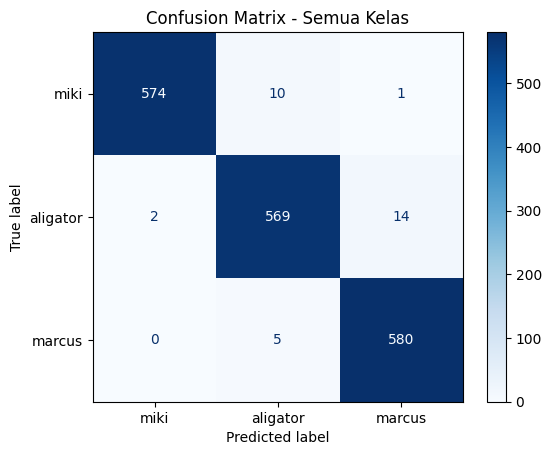

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.98      0.99       585
    aligator       0.97      0.97      0.97       585
      marcus       0.97      0.99      0.98       585

    accuracy                           0.98      1755
   macro avg       0.98      0.98      0.98      1755
weighted avg       0.98      0.98      0.98      1755

              precision    recall  f1-score      support
miki           0.996528  0.981197  0.988803   585.000000
aligator       0.974315  0.972650  0.973482   585.000000
marcus         0.974790  0.991453  0.983051   585.000000
accuracy       0.981766  0.981766  0.981766     0.981766
macro avg      0.981878  0.981766  0.981778  1755.000000
weighted avg   0.981878  0.981766  0.981778  1755.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

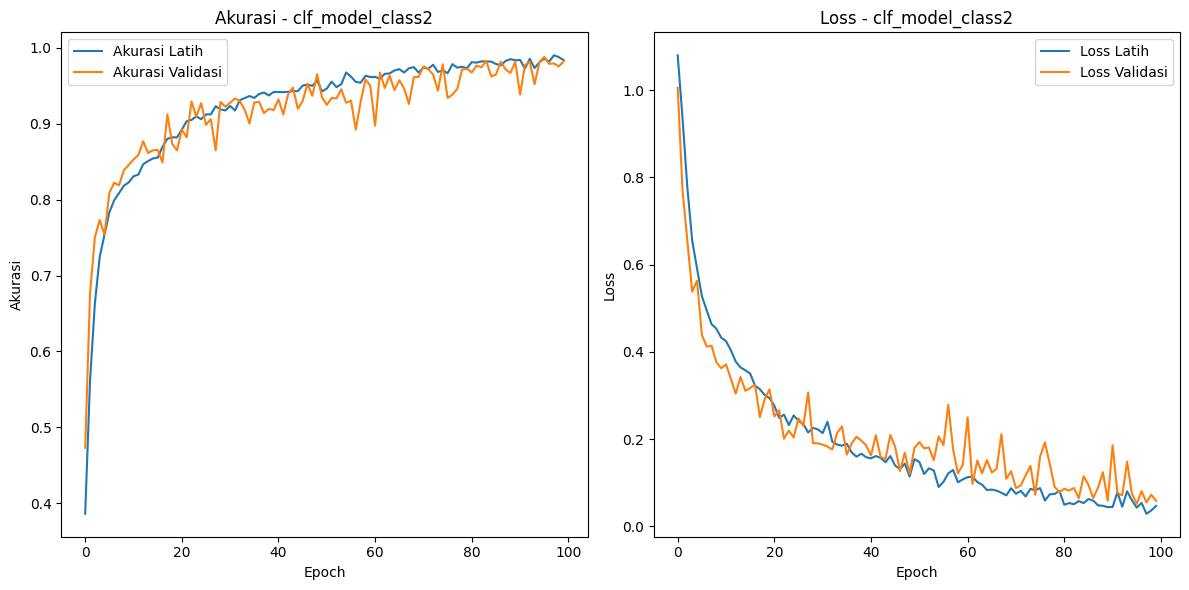

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
def visualize_all_test_images(image_paths, mask_paths, labels, masked_image_paths, clf_model_class1, label_map, max_visualize=None):
    label_names = label_map
    num_samples = len(image_paths)

    if max_visualize is not None:
        num_samples = min(num_samples, max_visualize)

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]
        masked_image_path = masked_image_paths[i]
        true_label_idx = labels[i]

        # Load original image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        # Load ground truth mask (if available)
        try:
            mask_raw = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
            gt_mask = tf.image.resize(gt_mask, [128, 128])
            gt_mask = tf.cast(gt_mask, tf.float32)
        except:
            gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

        # Load masked image (hasil segmentasi offline)
        masked_image_raw = tf.io.read_file(masked_image_path)
        masked_image = tf.image.decode_jpeg(masked_image_raw, channels=3)
        masked_image = tf.image.resize(masked_image, [128, 128])
        masked_image = tf.cast(masked_image, tf.float32) / 255.0

        # Predict label with classifier
        pred_probs = clf_model_class1(tf.expand_dims(masked_image, 0), training=False)
        pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

        # Convert label index to string
        true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
        pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

        # Visualisasi
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(image.numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(masked_image.numpy())
        axes[2].set_title("Masked Image (Hasil Segmentasi)")
        axes[2].axis('off')

        axes[3].imshow(masked_image.numpy())
        axes[3].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
        axes[3].axis('off')

        filename = os.path.basename(image_path)
        plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


In [ ]:
visualize_all_test_images(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    labels=test_labels,
    masked_image_paths=[os.path.join("maskedrsunet02_test", os.path.basename(p)) for p in test_image_paths],  # list of saved masked image filepaths
    clf_model_class1=clf_model_class1,
    label_map=label_map,
    max_visualize=10
)